## Data models

In [1]:
from typing import List
from typing import Callable
from typing import Tuple

class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
        self.centerX = x+width/2
        self.centerY = y+height/2
    
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
def decodeIntList(lst: List[str]) -> List[int]:
    return list(map(int, lst))

def decodeFloatList(lst: List[str]) -> List[float]:
    return list(map(float, lst))

def decodeRectangles(lst: List[str], idents: List[str]) -> List[Rectangle]:
    return list(map(decodeRectangle, *(lst,idents)))

def decodeRectangle(rec: str, ident: str) -> Rectangle:
    x,y,w,h = rec.split(',')
    return Rectangle(x=int(x), y=int(y), width=int(w), height=int(h), ident=ident)


class Individual:
    def __init__(self, iteration: int, objectiveValue: int, paintingSeq: List[int], paintingSeqDecoded: List[int], paintingSeqRandomKey: List[float], slicingOrderDecoded: List[int], slicingOrderRandomKey: List[float], orientations: List[str], orientationsCapped: List[str], orientationsResolved: List[str], paintingAllocatedSpace: List[Rectangle], paintingPlacement: List[Rectangle]):
        self.iteration = iteration
        self.objectiveValue = objectiveValue
        self.paintingSeq = paintingSeq
        self.paintingSeqDecoded = paintingSeqDecoded
        self.paintingSeqRandomKey = paintingSeqRandomKey
        self.slicingOrderDecoded = slicingOrderDecoded
        self.slicingOrderRandomKey = slicingOrderRandomKey
        self.orientations = orientations
        self.orientationsCapped = orientationsCapped
        self.orientationsResolved = orientationsResolved
        self.paintingAllocatedSpace = paintingAllocatedSpace
        self.paintingPlacement = paintingPlacement
        
    @staticmethod
    def create(json: dict) -> 'Individual':
        return Individual(
            iteration=int(json['iteration']),
            objectiveValue=float(json['objectiveValue']),
            paintingSeq=json['paintingSeq'],
            paintingSeqDecoded=json['paintingSeqDecoded'],
            paintingSeqRandomKey=decodeFloatList(json['paintingSeqRandomKey']),
            slicingOrderDecoded=decodeIntList(json['slicingOrderDecoded']),
            slicingOrderRandomKey=decodeFloatList(json['slicingOrderRandomKey']),
            orientations=json['orientations'],
            orientationsCapped=json['orientationsCapped'],
            orientationsResolved=json['orientations'], # TODO provide resolved orientations
            paintingAllocatedSpace=decodeRectangles(json['paintingAllocatedSpace_XYWH'], json['paintingSeqDecoded']),
            paintingPlacement=decodeRectangles(json['paintingPlacement_XYWH'], json['paintingSeqDecoded']))
    
class Painting:
    def __init__(self, ident: str, width: int, height: int):
        self.ident = ident
        self.width = width
        self.height = height
        
    @staticmethod
    def create(json: dict) -> 'Painting':
        return Painting(
            ident=json['ident'],
            width=int(json['width']),
            height=int(json['height']))
    
class HallOfFameRecord:
    def __init__(self, iteration: int, objectiveMin: float, objectiveMax: float, objectiveAvg: float, bestIndividual: Individual):
        self.iteration = iteration
        self.objectiveMin = objectiveMin
        self.objectiveMax = objectiveMax
        self.objectiveAvg = objectiveAvg
        self.bestIndividual = bestIndividual
    
    @staticmethod
    def create(json: dict) -> 'HallOfFameRecord':
        return HallOfFameRecord(
            iteration=int(json['iteration']),
            objectiveMin=float(json['objectiveMin']),
            objectiveMax=float(json['objectiveMax']),
            objectiveAvg=float(json['objectiveAvg']),
            bestIndividual=Individual.create(json['bestIndividual']))
            
class GaResult:
    def __init__(self, bestIndividual: Individual, hallOfFame: List[HallOfFameRecord]):
        self.bestIndividual = bestIndividual
        self.hallOfFame = hallOfFame
        
    @staticmethod
    def create(json: dict) -> 'GaResult':
        return GaResult(
            bestIndividual=Individual.create(json['bestIndividual']),
            hallOfFame=list(map(HallOfFameRecord.create, json['hallOfFame']['records'])))
    
class GaParameters:
    def __init__(self, maxNumberOfIter: int, populationSize: int, maximumWildCardCount: int, geneticAlgorithm: str, mate: str, mutate: str, select: str):
        self.maxNumberOfIter = maxNumberOfIter
        self.populationSize = populationSize
        self.maximumWildCardCount = maximumWildCardCount
        self.geneticAlgorithm = geneticAlgorithm
        self.mate = mate
        self.mutate = mutate
        self.select = select
        
    @staticmethod
    def create(json: dict) -> 'GaParameters':
        return GaParameters(
            maxNumberOfIter=int(json['maxNumberOfIter']),
            populationSize=int(json['populationSize']),
            maximumWildCardCount=int(json['maximumWildCardCount']),
            geneticAlgorithm=json['geneticAlgorithm'],
            mate=json['mate'],
            mutate=json['mutate'],
            select=json['select'])

class Layout:
    def __init__(self, width: int, height: int, evalFunc: str):
        self.width = width
        self.height = height
        self.evalFunc = evalFunc
        self.boundingRectangle = Rectangle(width=width, height=height, x=0, y=0, ident="")
        
    @staticmethod
    def create(json: dict) -> 'Layout':
        return Layout(width=json['width'], height=json['height'], evalFunc=json['evalFunc'])
    
class Flow:
    def __init__(self, src: int, dst: int, flow: float):
        self.src = src
        self.dst = dst
        self.flow = flow
        
    @staticmethod
    def create(json: dict) -> 'Flow':
        return Flow(
            src=int(json['from']),
            dst=int(json['to']),
            flow=float(json['flow']))
    
class InstanceParameters:
    def __init__(self, layout: Layout, paintings: List[Painting], paintingsFlow: List[Flow]):
        self.layout = layout
        self.paintings = paintings
        self.paintingsFlow = paintingsFlow
        
    @staticmethod
    def create(json: dict) -> 'InstanceParameters':
        return InstanceParameters(
            layout=Layout.create(json['layout']),
            paintings=list(map(Painting.create, json['paintings'])),
            paintingsFlow=list(map(Flow.create, json['paintingsFlow'])))
    
class ObjectiveParameters:
    def __init__(self, name: str, params: dict):
        self.name = name
        self.params = params
        
    @staticmethod
    def create(json: dict) -> 'ObjectiveParameters':
        return ObjectiveParameters(
            name=json['name'],
            params=json['params'])
        

class ComputationResult:
    def __init__(self, applicationVersion: str, createdAt: str, durationMillis: int, gaResult: GaResult, gaParameters: GaParameters, instanceParameters: InstanceParameters, objectiveParameters: ObjectiveParameters, name: str = None):
        self.applicationVersion = applicationVersion
        self.createdAt = createdAt
        self.durationMillis = durationMillis
        self.gaResult = gaResult
        self.gaParameters = gaParameters
        self.instanceParameters = instanceParameters
        self.objectiveParameters = objectiveParameters
        self.name = name
        
    @staticmethod
    def createWithName(name: str, json: dict):
        compRes = ComputationResult.create(json)
        compRes.name = name
        return compRes
    
    @staticmethod
    def create(json: dict) -> 'ComputationResult':
        return ComputationResult(
            applicationVersion=json['applicationVersion'],
            createdAt=json['createdAt'],
            durationMillis=int(json['durationMillis']),
            gaResult=GaResult.create(json['gaResult']),
            gaParameters=GaParameters.create(json['gaParameters']),
            instanceParameters=InstanceParameters.create(json['instanceParameters']),
            objectiveParameters=ObjectiveParameters.create(json['objectiveParameters']))
    
class Dataset:
    def __init__(self, name: str, instanceParameters: InstanceParameters):
        self.name = name
        self.instanceParameters = instanceParameters
        self.data = instanceParameters
        
    @staticmethod
    def create(json: dict) -> 'Dataset':
        return Dataset(
            name=json['name'],
            instanceParameters=InstanceParameters.create(json['data']))

## Copy helper

In [12]:
import os
import shutil

sourceDir = './figures'
destDir = '/home/slarty/Documents/master-thesis/src/thesis/figures'

for filename in os.listdir(sourceDir):
    if filename.endswith('.pdf'):
        shutil.copy(os.path.join(sourceDir, filename), destDir)

## Loading computation result

In [2]:
from pathlib import Path
import json
import glob

def _getDirPrefix(name: str) -> int:
    return int(name.split('_')[0])

def loadLatestComputationResult(resultDir='/home/slarty/Documents/master-thesis/src/impl/out') -> ComputationResult:
    dirs = [x for x in Path(resultDir).iterdir() if x.is_dir()]
    latest, prefix = dirs[0], _getDirPrefix(dirs[0].name)
    for d in dirs:
        k = _getDirPrefix(d.name)
        if k > prefix:
            latest, prefix = d, k
    return loadComputationResult(str(latest.resolve()))

def loadComputationResult(path: str, compResultFileName='computation_result.json') -> ComputationResult:
    print(f'loading: {path}')
    with open(path + '/' + compResultFileName, 'r') as f:
        data = json.load(f)
    return ComputationResult.createWithName(path.split('/')[-1], data)

def findDirectoriesWithFile(startingDir, fileNameToSearch='computation_result.json'):
    # Use glob to find all directories that contain the file
    directories = glob.glob(os.path.join(startingDir, f'**/{fileNameToSearch}'), recursive=True)
    return [os.path.dirname(path) for path in directories]

def loadComputationResultBatch(startingDir, addName=False, addInstanceSize=False) -> List[ComputationResult]:
    def _addName(compRes, dirPath):
        compRes.name = os.path.basename(dirPath).rsplit('_',1)[0].split('_', 1)[1] # magic
        compRes.path = dirPath
    
    def _addInstanceSize(compRes):
        compRes.size = len(compRes.instanceParameters.paintings)
    
    def _applyHooks(compRes, dirPath):
        if addName:
            _addName(compRes, dirPath)
        if addInstanceSize:
            _addInstanceSize(compRes)
        return compRes
            
    return [ _applyHooks(loadComputationResult(d),d) for d in findDirectoriesWithFile(startingDir)]

## Loading dataset

In [3]:
import os
import fnmatch
import json

def findDatasetPath(name, datasetDir='../datasets') -> str:
    for root, dirs, files in os.walk(datasetDir):
        for filename in fnmatch.filter(files, f"{name}.json"):
            return os.path.join(root, filename)
    raise FileNotFoundError(f"No file found with name {name}.json in directory {datasetDir}")

def loadDataset(name, datasetDir='/home/slarty/Documents/master-thesis/src/impl/public/datasets') -> Dataset:
    path = findDatasetPath(name, datasetDir)
    print(f'Loading {path}')
    with open(path, 'r') as f:
        data = json.load(f)
    return Dataset.create(data)

## Flow matrix

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/random/random_10.json


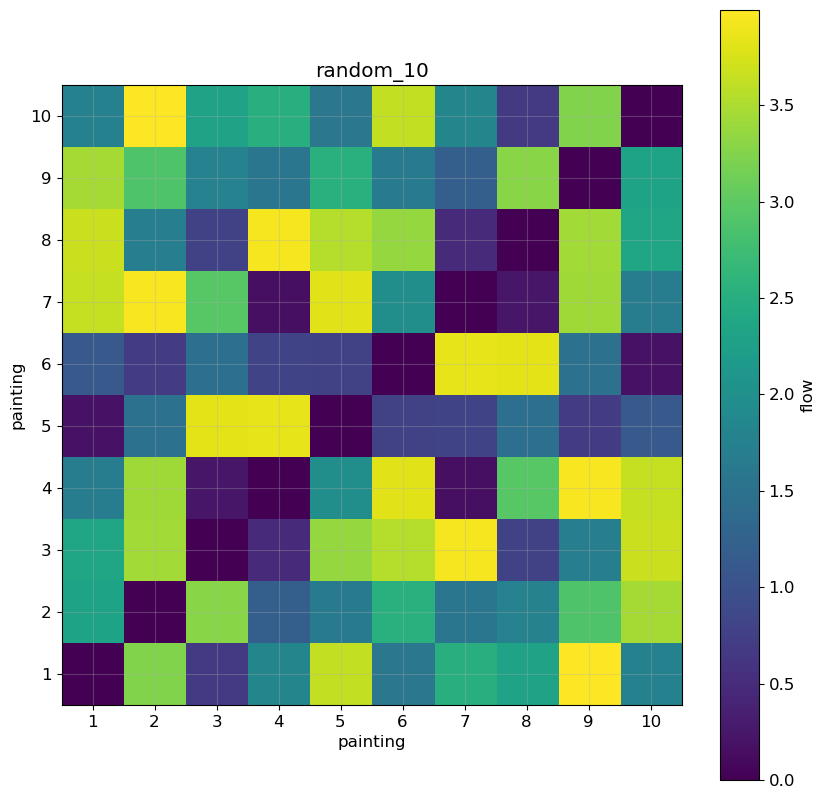

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/random/random_20.json


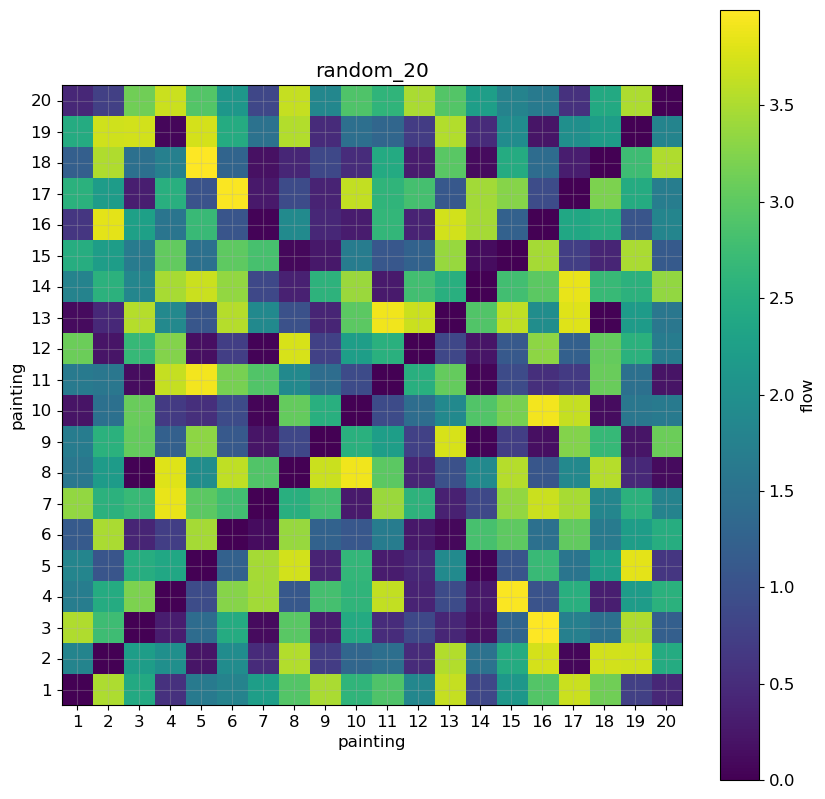

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/packing/packing_10.json


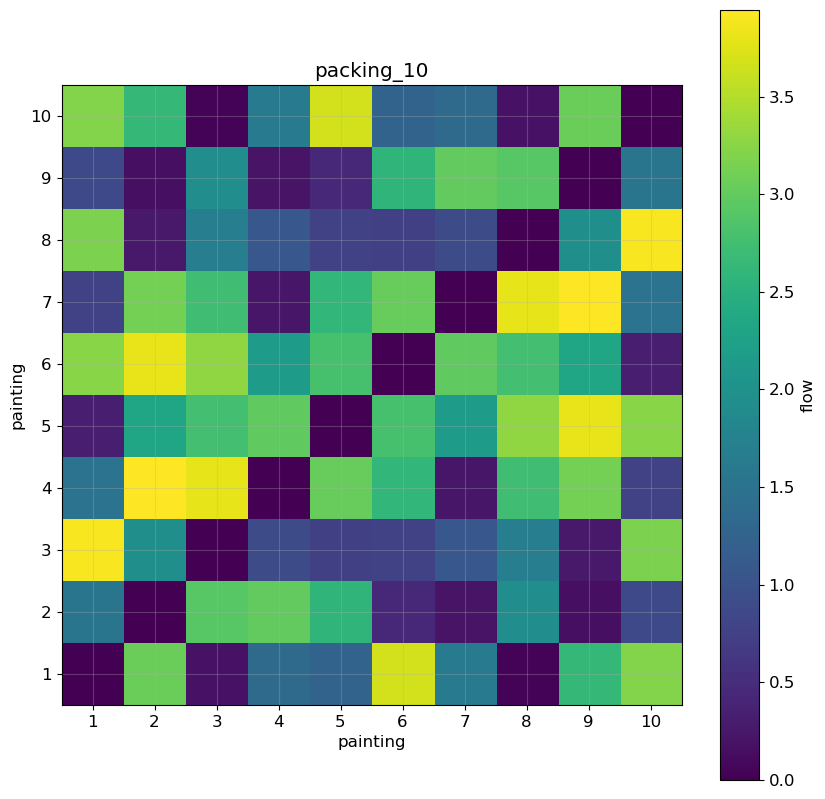

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/packing/packing_20.json


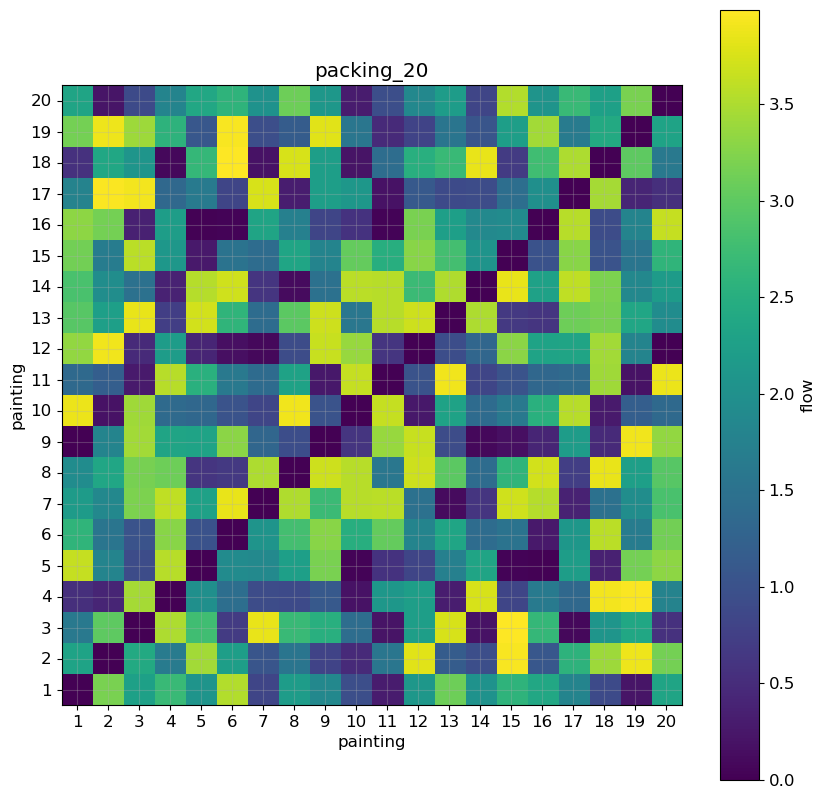

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_3_10.json


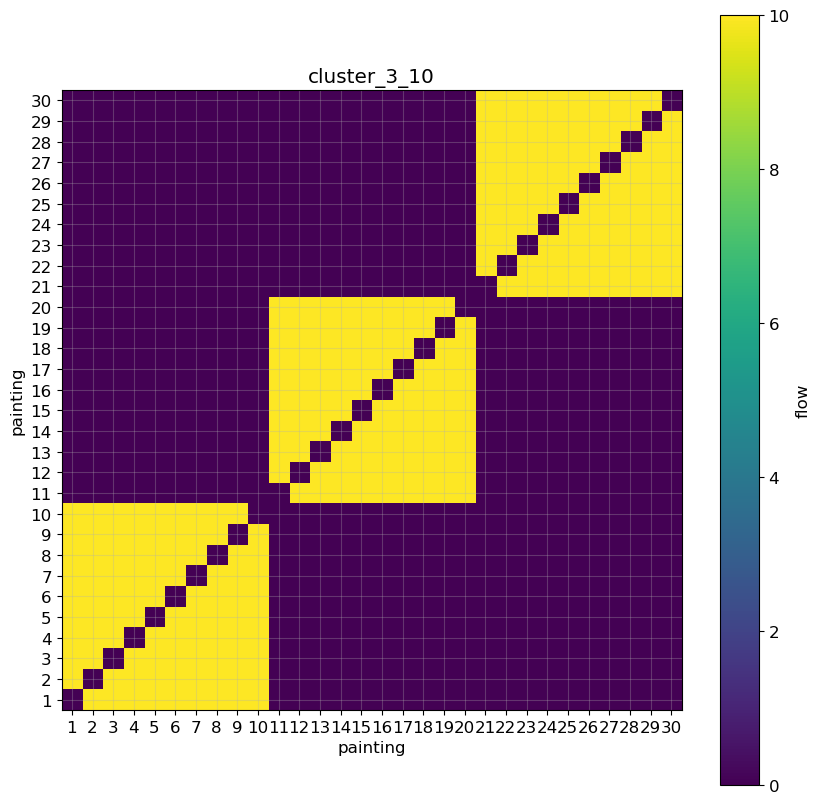

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_4_20.json


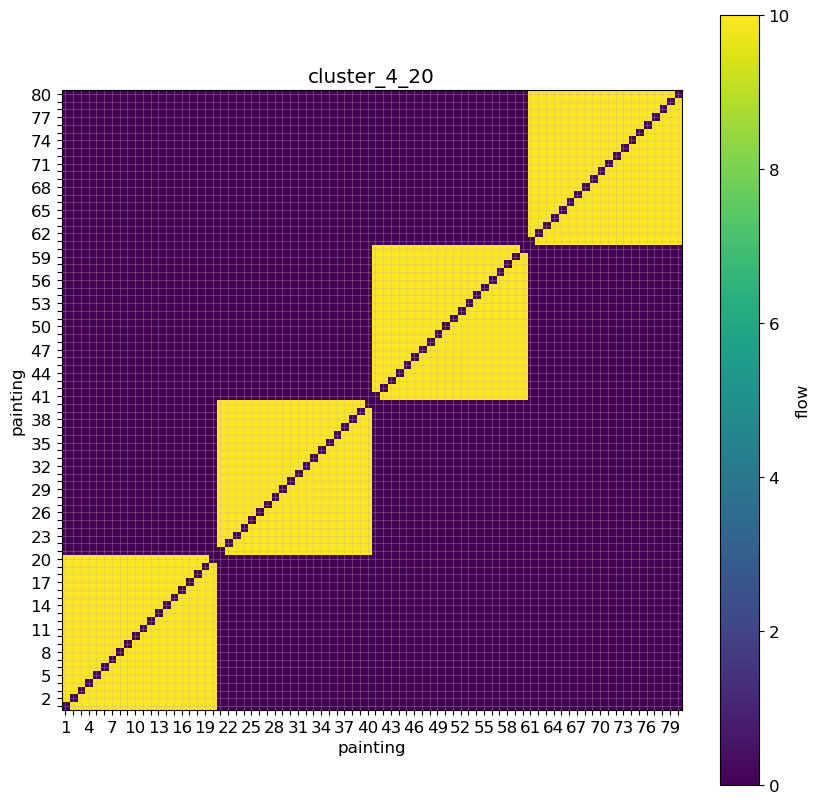

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/biased_sparse_cluster/biased_sparse_cluster_3_10.json


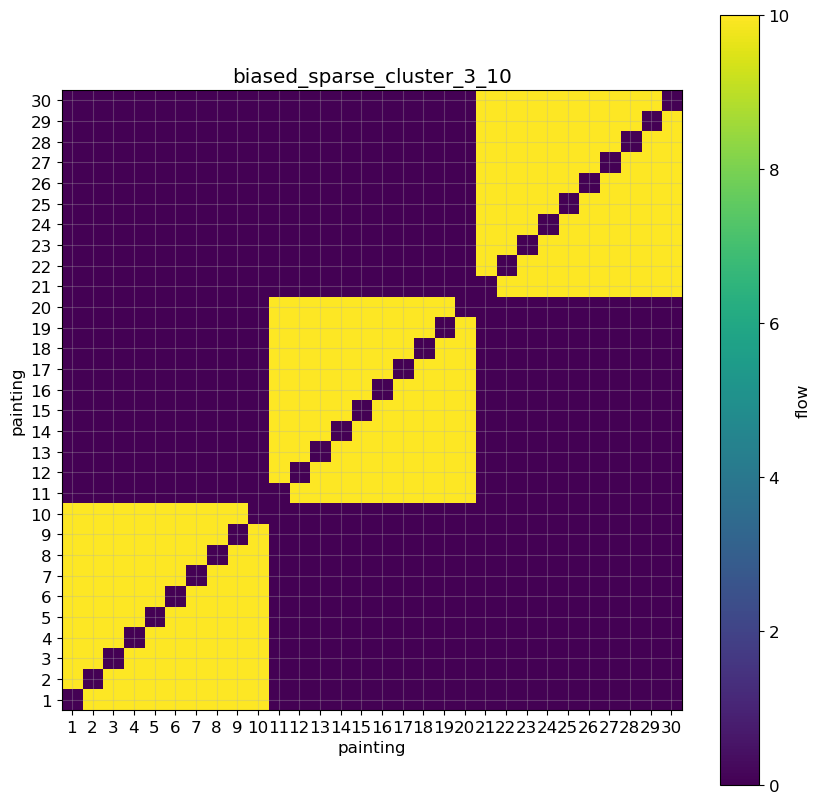

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as CM
plt.rcParams.update({'font.size': 12})

for name, size in [('random_10', 10), ('random_20', 20), ('packing_10', 10), ('packing_20', 20), ('cluster_3_10', 30), ('cluster_4_20', 80),
                  ('biased_sparse_cluster_3_10', 30)]:
    dataset = loadDataset(name)
    flows = np.zeros((size,size), dtype=float)
    for f in dataset.data.paintingsFlow:
        x,y = size-f.src, f.dst-1
        flows[x,y] = f.flow
        flows[size-x-1, size-y-1] = f.flow
        
    # A = flows
    # mask = np.rot90(np.tri(flows.shape[0], k=-1), k=3)
    # A = np.ma.array(A, mask=mask) # mask out the lower triangle
    # cmap = CM.get_cmap('viridis', size) # jet doesn't have white color
    # cmap.set_bad('w') # default value is 'k'
    # print(flows)
    A = flows
    # print(A)
    
    fig = plt.figure(figsize=(10, 10))
    plt.xlabel('painting')
    plt.ylabel('painting')
    xticks = list(range(0,size)), list(range(1,size+1))
    yticks = list(range(0,size)), list(range(size, 0, -1))
    if size > 40:
        for i in range(0, len(xticks[1])):
            if i % 3 != 0:
                xticks[1][i] = ''
                yticks[1][i] = ''
        
    plt.xticks(*xticks)
    plt.yticks(*yticks)
    plt.imshow(A, interpolation='nearest')#, cmap=cmap)
    plt.title(name)
    plt.grid(True, alpha=0.3)
    cbar = plt.colorbar()
    cbar.set_label('flow')
    plt.savefig(f"figures/heatmap_{name}.pdf")
    plt.show()

## Helpers

In [5]:
import pandas as pd

def compResToDf(compResLst: List[ComputationResult]) -> pd.DataFrame:
    def getAttrNested(obj, name, sp='.'):
        # print(name, obj.path)
        val = obj
        for attr in name.split(sp):
            val = getattr(val, attr)
        return val
            
    colsLong =['name',
           'gaResult.bestIndividual.iteration',
           'gaResult.bestIndividual.objectiveValue',
           'durationMillis',
           'gaParameters.maxNumberOfIter',
           'gaParameters.populationSize',
           'gaParameters.maximumWildCardCount',
           'size',
              ] 
    data = []
    for compRes in compResLst:
        record = []
        record.extend([getAttrNested(compRes, name) for name in colsLong])
        record.append(np.array([x.objectiveAvg for x in compRes.gaResult.hallOfFame]))
        data.append(record)
    return pd.DataFrame(data, columns=map(lambda x: x.split('.')[-1], colsLong+['avgObjTS']))

In [6]:
def smooth(x, y, k=3):
    """ Just for nice smooth graphs """
    from scipy.interpolate import make_interp_spline, BSpline
    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(min(x), max(x), 300) 

    spl = make_interp_spline(x, y, k)  # type: BSpline
    power_smooth = spl(xnew)
    
    return xnew, power_smooth

def addGridToFigure():
    plt.rc('axes', axisbelow=True)
    plt.grid(True)
        
def plotter(x, y, label, title, legendTitle, ncol=1, scatterDotSize=2, fontsize=10,
           xlabel='', ylabel=''):
    plt.plot(*smooth(x,y), label=label)
    plt.scatter(x, y, s=scatterDotSize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    addGridToFigure()
    lgd = plt.legend(title=legendTitle, fontsize=fontsize, ncol=1)

## Population size x best solution

In [7]:
r = loadComputationResultBatch('./out/population_size', addName=True, addInstanceSize=True)
df = compResToDf(r)
df['N'] = (df.populationSize / df['size']).astype('int32')
dfTS = df.groupby([df.name, df.N])['avgObjTS'].mean()

loading: ./out/population_size/1/001_random_10_3855E
loading: ./out/population_size/1/002_random_10_52D30
loading: ./out/population_size/1/003_random_10_3AE77
loading: ./out/population_size/1/004_random_20_205EC
loading: ./out/population_size/1/005_random_20_29A7D
loading: ./out/population_size/1/006_random_20_E0B4F
loading: ./out/population_size/2/007_random_10_2F986
loading: ./out/population_size/2/008_random_10_F7C91
loading: ./out/population_size/2/010_random_20_40B29
loading: ./out/population_size/2/011_random_20_CF770
loading: ./out/population_size/2/012_random_20_6C87A
loading: ./out/population_size/3/013_random_10_E0C17
loading: ./out/population_size/3/014_random_10_1FB2C
loading: ./out/population_size/3/015_random_10_D1877
loading: ./out/population_size/3/016_random_20_63B5E
loading: ./out/population_size/3/017_random_20_FAE68
loading: ./out/population_size/3/018_random_20_831DD
loading: ./out/population_size/4/019_random_10_6A845
loading: ./out/population_size/4/020_random_10

In [13]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({'font.size': 9})

for name in ['random_10', 'random_20']:
    for N in [10, 50, 100]:
        label = f'{N}'
        ts = dfTS[name, N]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=name, legendTitle='population\nscaling factor', scatterDotSize=1,
               fontsize=9, xlabel='iteration', ylabel='average population objective')
    plt.savefig(f'figures/pop_size_{name}.pdf')
    plt.show()

KeyError: ('random_10', 10)

## Cluster

In [9]:
r = loadComputationResultBatch('./out/cluster', addName=True, addInstanceSize=True)
df = compResToDf(r)
df['N'] = (df.populationSize / df['size']).astype('int32')
dfTS = df.groupby([df.name, df.N])['avgObjTS'].mean()

loading: ./out/cluster/1/061_cluster_3_10_C5DEF
loading: ./out/cluster/1/062_cluster_4_20_FE9BB
loading: ./out/cluster/2/063_cluster_3_10_923C4
loading: ./out/cluster/2/064_cluster_4_20_CBA9C
loading: ./out/cluster/3/065_cluster_3_10_A16D9
loading: ./out/cluster/3/066_cluster_4_20_593D9
loading: ./out/cluster/4/067_cluster_3_10_66222
loading: ./out/cluster/4/068_cluster_4_20_D9D5D


In [10]:
df

,name,iteration,objectiveValue,durationMillis,maxNumberOfIter,populationSize,maximumWildCardCount,size,avgObjTS,N
0,cluster_3_10,311,21690.52,850717,1000,300,0,30,"[33844.48, 32082.56, 30962.7, 30724.33, 30396....",10
1,cluster_4_20,421,199640.20,5876810,1000,400,0,80,"[271608.74, 261435.0, 256655.03, 255618.76, 25...",5
2,cluster_3_10,283,16387.48,851171,1000,300,0,30,"[34178.76, 32183.85, 31097.82, 30744.88, 30623...",10
3,cluster_4_20,763,189338.06,5857895,1000,400,0,80,"[272491.69, 262964.62, 257631.76, 255485.06, 2...",5
4,cluster_3_10,536,19233.45,851219,1000,300,0,30,"[33850.89, 32033.48, 31069.7, 30744.37, 30546....",10
5,cluster_4_20,763,186726.22,5847154,1000,400,0,80,"[271520.16, 262559.36, 257101.99, 254890.31, 2...",5
6,cluster_3_10,448,20343.34,851917,1000,300,0,30,"[33719.5, 31793.69, 31017.24, 30834.87, 30661....",10
7,cluster_4_20,560,182243.54,5870746,1000,400,0,80,"[272104.86, 262550.55, 257692.71, 254887.66, 2...",5


KeyError: ('cluster_3_10', 50)

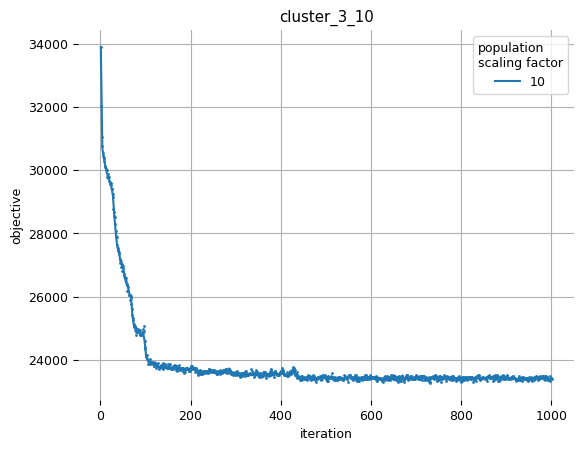

In [11]:
import matplotlib as mpl

mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

plt.rcParams.update({'font.size': 9})

for name in ['cluster_3_10', 'cluster_4_20']:
    for N in [10, 50, 100]:
        label = f'{N}'
        ts = dfTS[name, N]
        plotter(x=range(1, len(ts)+1), y=ts, label=label, title=name, legendTitle='population\nscaling factor', scatterDotSize=1,
               fontsize=9, xlabel='iteration', ylabel='objective')
    plt.savefig(f'figures/pop_size_{name}.pdf')
    plt.show()